# EYE FOR BLIND
This notebook will be used to prepare the capstone project 'Eye for Blind'

We need few libraries which can be grouped into several categories based on their functionality:

**Data processing and visualization:**

* pandas
* numpy
* os
* glob
* re
* PIL
* matplotlib
* WordCloud
* seaborn
* skimage
* tqdm




**Natural language processing and evaluation metrics:**

* nltk
* Counter
* train_test_split
* sentence_bleu

**Deep learning and machine learning:**

* tensorflow
* keras
* pickle

**Text-to-speech and audio:**

* gtts
* playsound

**Notebook and display:**

IPython

In [1]:

#Import all the required libraries

# Data processing and visualization:
import pandas as pd
import numpy as np
import os 
import glob
import re
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from wordcloud import WordCloud
import seaborn as sns
from tqdm import tqdm
import time
from skimage import io

# Natural language processing and evaluation metrics:
import nltk
from collections import Counter
from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import sentence_bleu

# Deep Learning and machine Learning
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils import plot_model
import pickle 

#Text-to-speech and audio:
#from gtts import gTTS
#from playsound import playsound

#Notebook and display
from IPython import display

#To suppress warnings in Python
import warnings
warnings.filterwarnings("ignore")

In [2]:
 #For checking whether the TensorFlow version installed on the Colab virtual machine was built with CUDA support
 tf.test.is_built_with_cuda()

True

Let's read the dataset

## Data understanding
1.Import the dataset and read image & captions into two seperate variables

2.Visualise both the images & text present in the dataset

3.Create a dataframe which summarizes the image, path & captions as a dataframe

4.Create a list which contains all the captions & path

5.Visualise the top 30 occuring words in the captions



In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
path='/content/drive/MyDrive/MachineLearning/EyeForBlind/kaggle'
os.environ['KAGGLE_CONFIG_DIR'] = path



The below code check if kaggle.json alreday exists if not then delete kaggle directory, and upload the token to a newly created directory and finishes off.

In [5]:
from google.colab import files
# Check if the kaggle.json file exists
if os.path.exists(f"{path}/kaggle.json"):
    print("Kaggle API token already found.")
    # Change the current directory to path
    os.chdir(path)

else:
    # Remove the existing kaggle directory
    os.system(f'rm -r {path}')

    # Create a new kaggle directory
    os.system(f'mkdir {path}')
    
    # Change the current directory to path
    os.chdir(path)
    
    # expire any previous token(s) and upload recreated token
    files.upload() 

# Set the file permissions for the kaggle.json file
os.system(f'chmod 600 {path}/kaggle.json')
print("Kaggle API token successfully configured.")


Kaggle API token already found.
Kaggle API token successfully configured.


In [6]:
#download the dataset
! kaggle datasets download -d 'adityajn105/flickr8k'

# unzip the dataset
! unzip flickr8k.zip -d '/data'


Streaming output truncated to the last 5000 lines.
  inflating: /data/Images/2844846111_8c1cbfc75d.jpg  
  inflating: /data/Images/2844963839_ff09cdb81f.jpg  
  inflating: /data/Images/2845246160_d0d1bbd6f0.jpg  
  inflating: /data/Images/2845691057_d4ab89d889.jpg  
  inflating: /data/Images/2845845721_d0bc113ff7.jpg  
  inflating: /data/Images/2846037553_1a1de50709.jpg  
  inflating: /data/Images/2846785268_904c5fcf9f.jpg  
  inflating: /data/Images/2846843520_b0e6211478.jpg  
  inflating: /data/Images/2847514745_9a35493023.jpg  
  inflating: /data/Images/2847615962_c330bded6e.jpg  
  inflating: /data/Images/2847859796_4d9cb0d31f.jpg  
  inflating: /data/Images/2848266893_9693c66275.jpg  
  inflating: /data/Images/2848571082_26454cb981.jpg  
  inflating: /data/Images/2848895544_6d06210e9d.jpg  
  inflating: /data/Images/2848977044_446a31d86e.jpg  
  inflating: /data/Images/2849194983_2968c72832.jpg  
  inflating: /data/Images/2850719435_221f15e951.jpg  
  inflating: /data/Images/28511

In [7]:
!rm flickr8k.zip

In [8]:

# Set the path to the unzipped files
path = '/data'

# Check if the path exists
if os.path.exists(path):
    # List all the files in the path
    files = os.listdir(path)
    # Print the list of files
    print(files)
else:
    print("Error: Path not found.")

['Images', 'captions.txt']


In [9]:
#Import the dataset and read the image into a seperate variable

images='/data/Images'

all_imgs = glob.glob(images + '/*.jpg',recursive=True)
print("The total images present in the dataset: {}".format(len(all_imgs)))

The total images present in the dataset: 8091


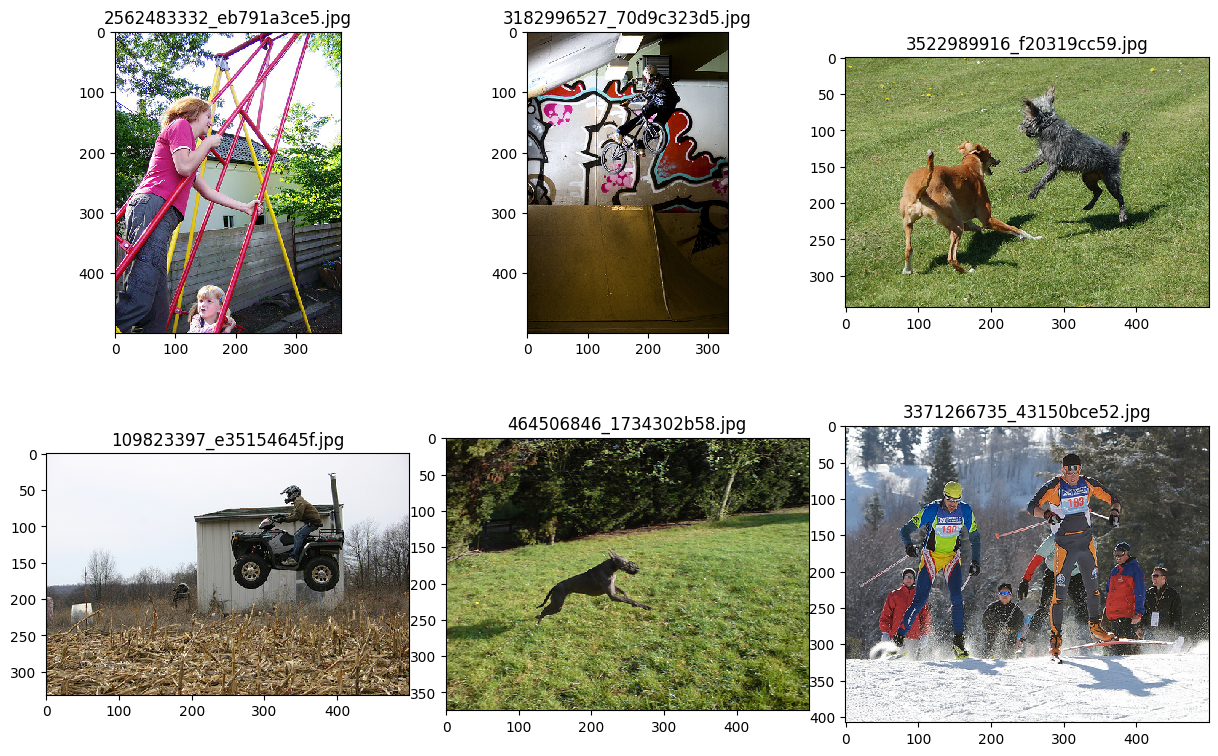

In [10]:
#Visualise both the images & text present in the dataset
def print_image(index):
    image_path = all_imgs[index]
    img = io.imread(image_path)
    img_name = os.path.basename(image_path)
    return img, img_name

fig, axs = plt.subplots(2,3, figsize=(15, 9), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .3, wspace=.1)

for i, ax in enumerate(axs.ravel()):
    img, name = print_image(i)
    ax.imshow(img, cmap=None, interpolation='none')
    ax.set_title(name)



In [11]:
#Import the dataset and read the text file into a seperate variable
text_file="/data/" + 'captions.txt'
def load_doc(filename):
    # oepn the file to read
    text = open(filename).read()
    return text

doc = load_doc(text_file)
print(doc[:300])

image,caption
1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg,A girl going into a wooden building .
1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg,A little girl climbing


Create a dataframe which summarizes the image, path & captions as a dataframe

Each image id has 5 captions associated with it therefore the total dataset should have 40455 samples.

In [12]:
def get_ImageId_Path_Caption(text):
    """
    getting caption file [doc] and 
    extarcting Image name as ID, path, and Its captions as Caption in different list and return all 3.    
    """
    
    lines = text.splitlines()[1:] # skipping first row as it only has column names
    Id, path, caption = [], [], []
    
    for line in lines:
        img_id, cap = line.split(',', 1)
        Id.append(img_id)
        caption.append(cap)
        path.append(os.path.join(images, img_id))
    
    return Id, path, caption


In [13]:
id,path,caption = get_ImageId_Path_Caption(doc)
all_img_id= id
all_img_vector=path
annotations= caption

df = pd.DataFrame(list(zip(all_img_id, all_img_vector,annotations)),columns =['ID','Path', 'Captions']) 
    
df

ID                                    Path  \
0      1000268201_693b08cb0e.jpg  /data/Images/1000268201_693b08cb0e.jpg   
1      1000268201_693b08cb0e.jpg  /data/Images/1000268201_693b08cb0e.jpg   
2      1000268201_693b08cb0e.jpg  /data/Images/1000268201_693b08cb0e.jpg   
3      1000268201_693b08cb0e.jpg  /data/Images/1000268201_693b08cb0e.jpg   
4      1000268201_693b08cb0e.jpg  /data/Images/1000268201_693b08cb0e.jpg   
...                          ...                                     ...   
40450   997722733_0cb5439472.jpg   /data/Images/997722733_0cb5439472.jpg   
40451   997722733_0cb5439472.jpg   /data/Images/997722733_0cb5439472.jpg   
40452   997722733_0cb5439472.jpg   /data/Images/997722733_0cb5439472.jpg   
40453   997722733_0cb5439472.jpg   /data/Images/997722733_0cb5439472.jpg   
40454   997722733_0cb5439472.jpg   /data/Images/997722733_0cb5439472.jpg   

                                                Captions  
0      A child in a pink dress is climbing up a set o...  
1                  A girl going into a wooden building .  
2       A little girl climbing into a wooden playhouse .  
3      A little girl climbing the stairs to her playh...  
4      A little girl in a pink dress going into a woo...  
...                                                  ...  
40450           A man in a pink shirt climbs a rock face  
40451           A man is rock climbing high in the air .  
40452  A person in a red shirt climbing up a rock fac...  
40453                    A rock climber in a red shirt .  
40454  A rock climber practices on a rock climbing wa...  

[40455 rows x 3 columns]

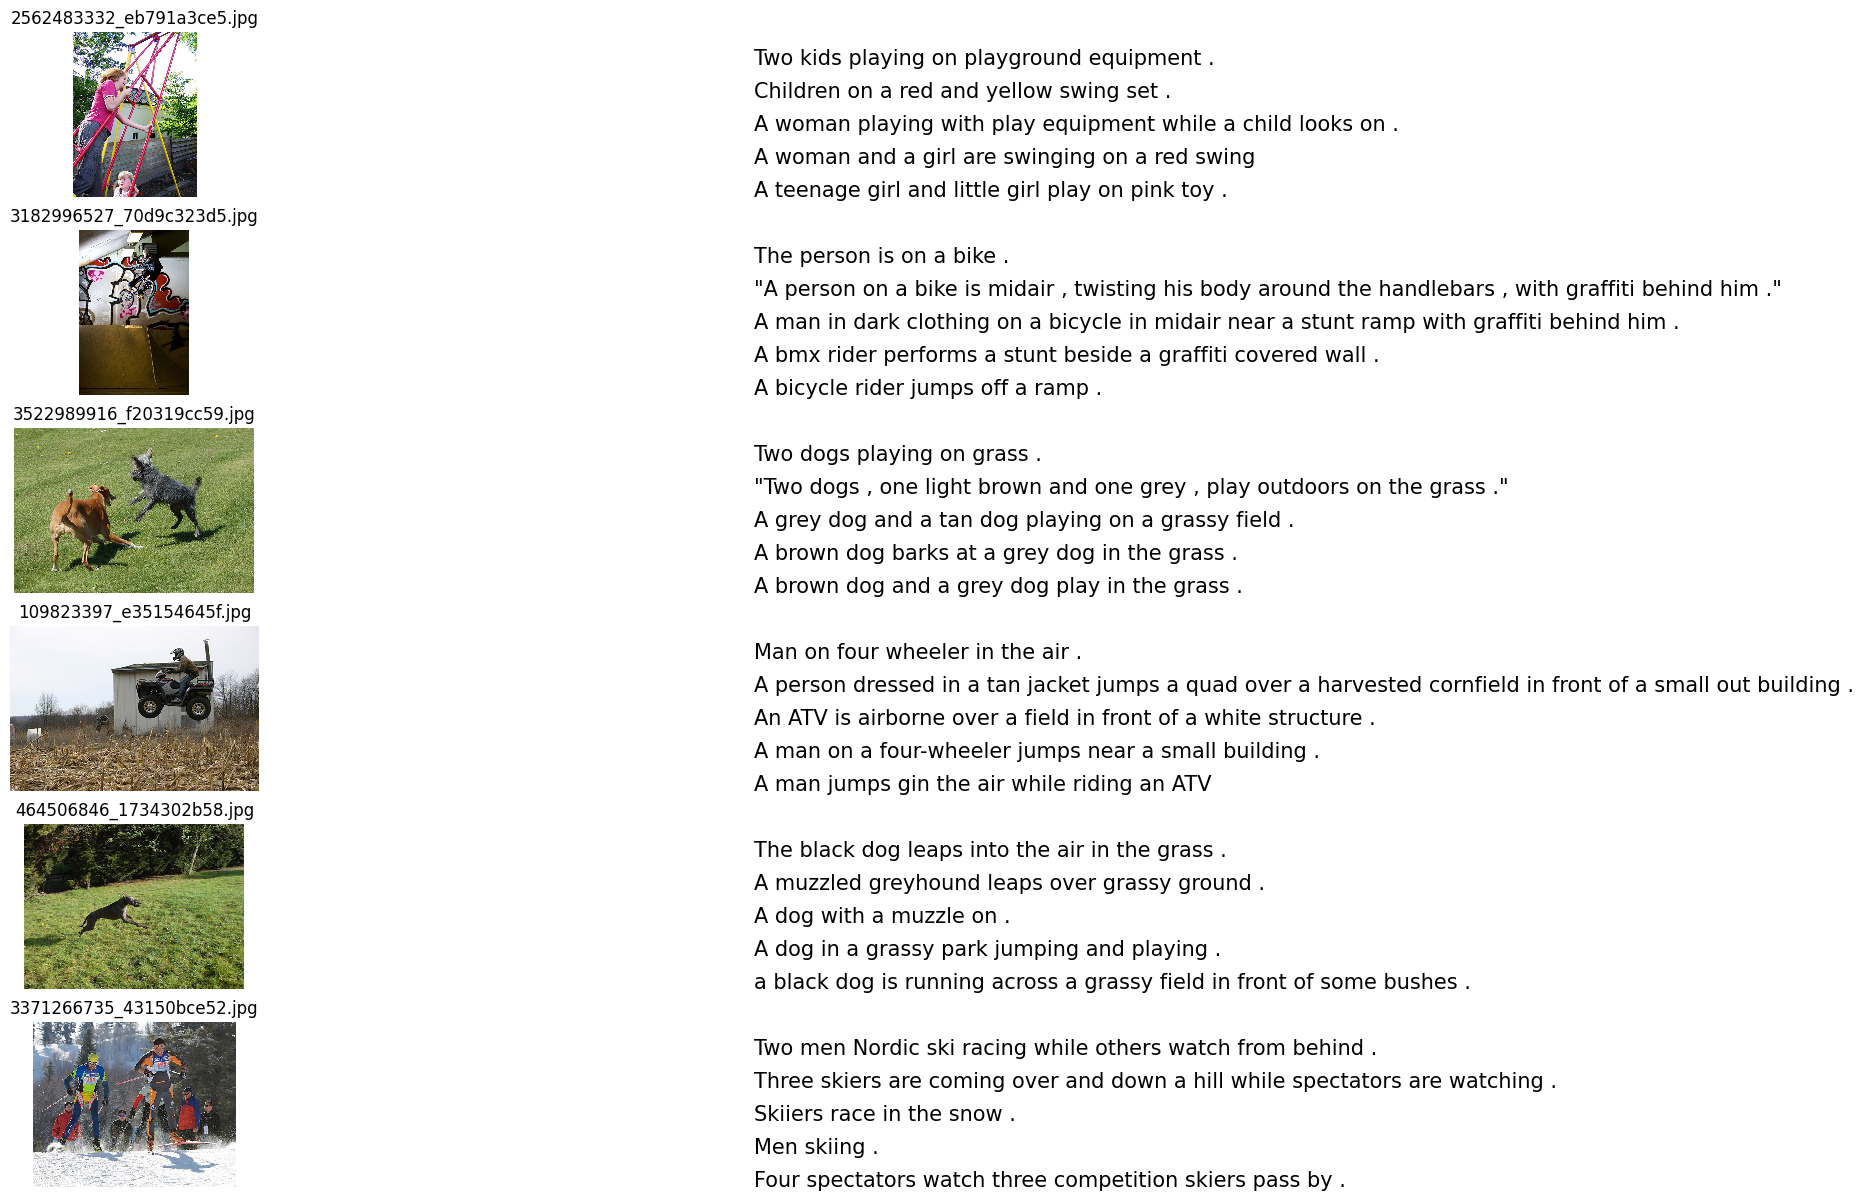

In [14]:
IMAGE_COUNT=6

#Create a IMAGE_COUNTx2 grid of subplots and adjust the spacing between them
fig, axs = plt.subplots(IMAGE_COUNT,2, figsize=(16, 15), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .20, wspace=1)

#Iterate over all the subplots
for i, ax in enumerate(axs.ravel()):
    # For even index subplot, plot the image
    if i % 2 == 0:
        img, name = print_image(i//2)
        ax.imshow(img, cmap=None, interpolation='none')
        ax.set_title(name)
        ax.axis('off')
    # For odd index subplot, plot the captions for the image  
    else:
        # Get the captions for the corresponding image name
        captions = list(df["Captions"].loc[df.ID==name].values)
        ax.set_xlim(0,1)
        ax.set_ylim(0,len(captions))
        ax.axis('off')
        # Iterate over all the captions and plot them on the subplot
        for j, caption in enumerate(captions):
            ax.text(0, j, caption, fontsize=15)


In [15]:
#Create a list which contains all the captions
#add the <start> & <end> token to all those captions as well
annotations=df.Captions.apply(lambda x:'<start> '+ x + ' <end>').to_list()


#Create a list which contains all the path to the images
all_img_path=df.Path.tolist()

print("Total captions present in the dataset: "+ str(len(annotations)))
print("Total images present in the dataset: " + str(len(all_img_path)))

Total captions present in the dataset: 40455
Total images present in the dataset: 40455


In [16]:
#Create the vocabulary & the counter for the captions
def create_vocab_counter(annot):
    list_vocab = []
    for sentence in annot:
        token = sentence.split()
        list_vocab.extend(token)
    return list_vocab

 #calling create_vocab_counter fucntion here
vocabulary= create_vocab_counter(annotations)
vocabulary=list(map(lambda x: x.lower(), vocabulary))
val_count = Counter(vocabulary)
val_count.most_common(40)


[('a', 61752),
 ('<start>', 40455),
 ('<end>', 40455),
 ('.', 34212),
 ('in', 18965),
 ('the', 18249),
 ('on', 10732),
 ('is', 9345),
 ('and', 8851),
 ('dog', 8126),
 ('with', 7761),
 ('man', 7238),
 ('of', 6712),
 ('two', 5224),
 ('white', 3935),
 ('black', 3825),
 ('boy', 3561),
 ('are', 3504),
 ('woman', 3385),
 ('girl', 3320),
 (',', 3210),
 ('to', 3173),
 ('wearing', 3061),
 ('at', 2905),
 ('people', 2856),
 ('water', 2779),
 ('red', 2672),
 ('young', 2607),
 ('brown', 2549),
 ('an', 2399),
 ('."', 2365),
 ('his', 2357),
 ('blue', 2266),
 ('dogs', 2122),
 ('running', 2073),
 ('through', 2031),
 ('playing', 2008),
 ('while', 1957),
 ('down', 1824),
 ('shirt', 1803)]

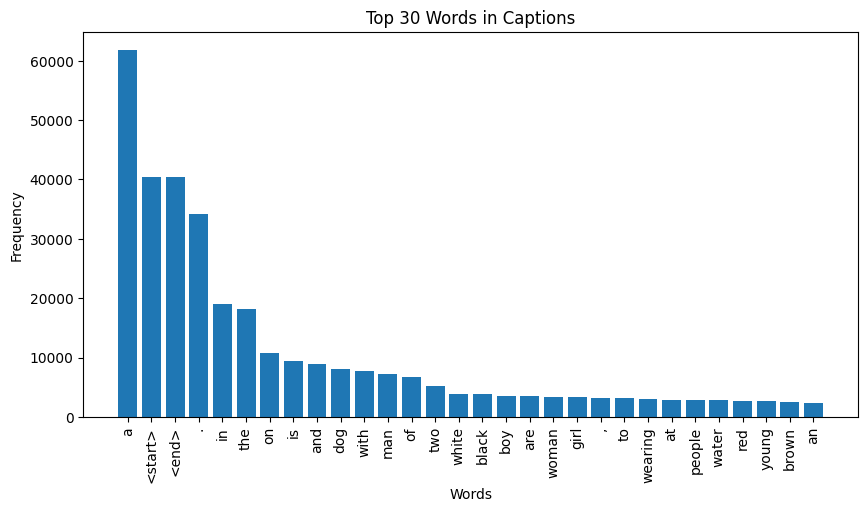

In [17]:
#Visualise the top 30 occuring words in the captions
top_words = dict(val_count.most_common(30))

plt.figure(figsize=(10,5))
plt.bar(top_words.keys(), top_words.values())
plt.title('Top 30 Words in Captions')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


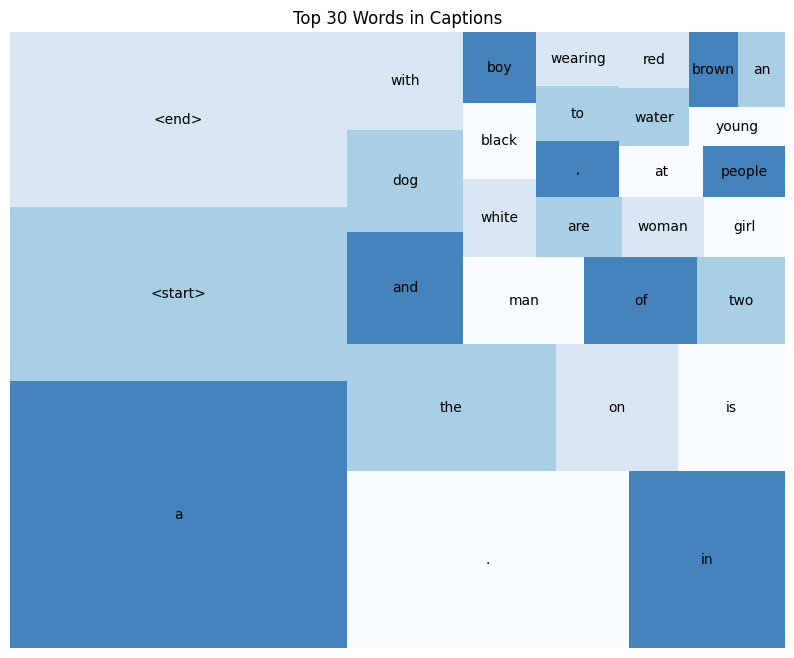

In [18]:
!pip install squarify
import squarify

# Create a tree map
plt.figure(figsize=(10, 8))
colors = plt.cm.Blues_r([0.2, 0.6, 0.8, 1])
squarify.plot(sizes=top_words.values(), label=top_words.keys(), color=colors, alpha=.8)
plt.axis('off')
plt.title('Top 30 Words in Captions')
plt.show()


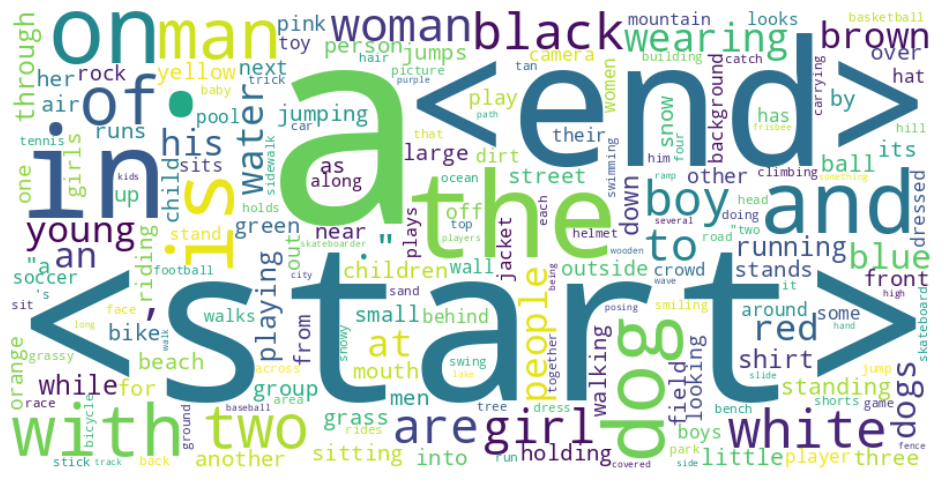

In [19]:

# create WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white')

# generate word cloud
wordcloud.generate_from_frequencies(val_count)

# plot word cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


## Pre-Processing the captions
1.Create the tokenized vectors by tokenizing the captions fore ex :split them using spaces & other filters. 
This gives us a vocabulary of all of the unique words in the data. Keep the total vocaublary to top 5,000 words for saving memory.

2.Replace all other words with the unknown token "UNK" .

3.Create word-to-index and index-to-word mappings.

4.Pad all sequences to be the same length as the longest one.

In [20]:
# create the tokenizer

# Set the maximum number of words to be used in the vocabulary
MAX_NUM_WORDS = 5000

# Tokenize the captions using Keras' Tokenizer
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token="<UNK>",filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(annotations)

# Convert the text captions to sequences of integers
sequences = tokenizer.texts_to_sequences(annotations)

# Get the word index of the tokenizer
word_index = tokenizer.word_index


In [21]:
print("Length of seqs: ",len(sequences))

Length of seqs:  40455


In [22]:
for i in range(3):
    print(sequences[i:i+1])
    print(annotations[i:i+1], "\n")

[[3, 2, 44, 5, 2, 91, 173, 8, 120, 52, 2, 394, 13, 395, 5, 29, 1, 671, 4]]
['<start> A child in a pink dress is climbing up a set of stairs in an entry way . <end>'] 

[[3, 2, 20, 317, 65, 2, 197, 118, 4]]
['<start> A girl going into a wooden building . <end>'] 

[[3, 2, 41, 20, 120, 65, 2, 197, 2438, 4]]
['<start> A little girl climbing into a wooden playhouse . <end>'] 



In [23]:
# Create word-to-index and index-to-word mappings.

tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'
len(tokenizer.word_counts)

8495

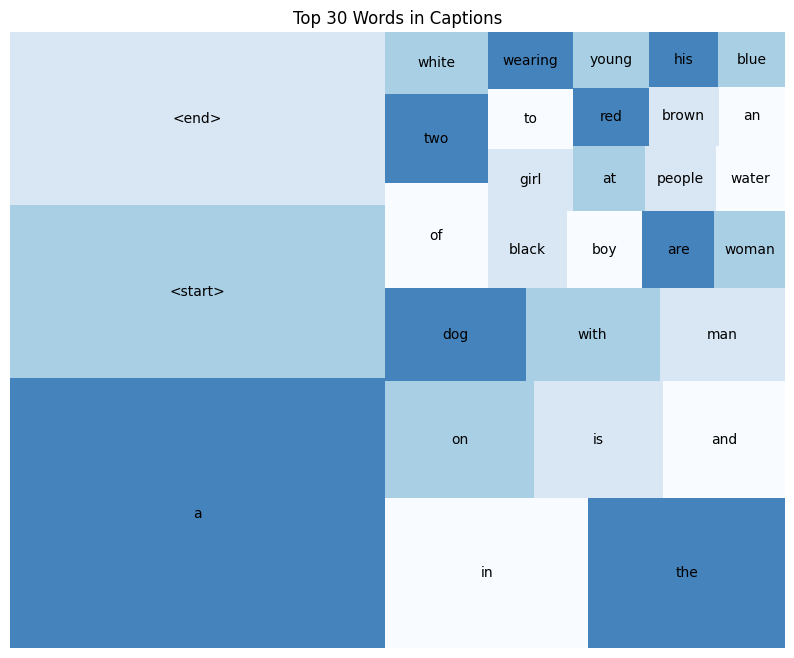

In [24]:
# Create a word count of your tokenizer to visualize the Top 30 occuring words after text processing

top_words = Counter(tokenizer.word_counts)
top_words = dict(top_words.most_common(30))

# Create a tree map
plt.figure(figsize=(10, 8))
colors = plt.cm.Blues_r([0.2, 0.6, 0.8, 1])
squarify.plot(sizes=top_words.values(), label=top_words.keys(), color=colors, alpha=.8)
plt.axis('off')
plt.title('Top 30 Words in Captions')
plt.show()

In [25]:
# Pad each vector to the max_length of the captions ^ store it to a vairable
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Define maximum length for padding
max_length = max(len(x) for x in sequences)

# Pad sequences
cap_vector = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

print("The shape of Caption vector is :" + str(cap_vector.shape))

The shape of Caption vector is :(40455, 39)


## Pre-processing the images

1.Resize them into the shape of (299, 299)

3.Normalize the image within the range of -1 to 1, such that it is in correct format for InceptionV3. 

### FAQs on how to resize the images::
* Since you have a list which contains all the image path, you need to first convert them to a dataset using <i>tf.data.Dataset.from_tensor_slices</i>. Once you have created a dataset consisting of image paths, you need to apply a function to the dataset which will apply the necessary preprocessing to each image. 
* This function should resize them and also should do the necessary preprocessing that it is in correct format for InceptionV3.


In [26]:
#write your code here to create the dataset consisting of image paths
new_path_file=sorted(set(all_img_vector))
dataset=tf.data.Dataset.from_tensor_slices(new_path_file)
dataset

<_TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [27]:

def preprocess_image(path):
    """
    
    """
    img = tf.io.read_file(path)
    # setting image channel as 3
    img = tf.image.decode_jpeg(img, channels=3)
    # resizing the image to (299,299)
    img = tf.image.resize(img, (299, 299))
    # preprocessing the image using inception_v3
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img

img_size = Image.open(all_img_vector[0]).size
img_preprocessed = preprocess_image(all_img_vector[0]).shape
print(f"Size of image before preprocessing: {img_size}")
print(f"Size of image after preprocessing: {img_preprocessed}") 

Size of image before preprocessing: (375, 500)
Size of image after preprocessing: (299, 299, 3)


In [28]:
#write your code here for creating the function. This function should return images & their path

def load_image(image_path):
    return preprocess_image(image_path),image_path
    

In [29]:
#write your code here for applying the function to the image path dataset, such that the transformed dataset should contain images & their path
BATCH_SIZE=32
dataset=dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(BATCH_SIZE)
dataset



<_BatchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None))>

## Load the pretrained Imagenet weights of Inception net V3

1.To save the memory(RAM) from getting exhausted, extract the features of the images using the last layer of pre-trained model. Including this as part of training will lead to higher computational time.

2.The shape of the output of this layer is 8x8x2048. 

3.Use a function to extract the features of each image in the train & test dataset such that the shape of each image should be (batch_size, 8*8, 2048)



In [30]:
# Load the InceptionV3 model.
image_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

# getting the input layer of InceptionV3() model: (None, None, None, 3)
input = image_model.input 
# getting the output layer of InceptionV3() model: (None, None, None, 2048)
hidden_layer = image_model.layers[-1].output 

print("Shape of Input:" , input.shape)
print("Shape of Output:", hidden_layer.shape)

image_features_extract_model = tf.keras.Model(input, hidden_layer) 

87910968/87910968 [==============================] - 5s 0us/step
Shape of Input: (None, None, None, 3)
Shape of Output: (None, None, None, 2048)


In [31]:
# write the code to apply the feature_extraction model to your earlier created dataset which contained images & their respective paths
# Once the features are created, you need to reshape them such that feature shape is in order of (batch_size, 8*8, 2048)

features_dict = {}
#loop through the dataset and extract the features of each image using the image_features_extract_model
for i, (image, path) in enumerate(tqdm(dataset)):
    features = image_features_extract_model(image)
    
    #reshape the extracted features to have shape (batch_size, 8*8, 2048) and store the features in the features_dict
    features = tf.reshape(features, (features.shape[0], -1, features.shape[3]))
    
    for j in range(features.shape[0]):
        # decode the path to get the filename of the image
        feat_path = path[j].numpy().decode("utf-8")
        # store the extracted features of the image in the features_dict using the filename as key
        features_dict[feat_path] = features[j].numpy()


100%|██████████| 253/253 [01:09<00:00,  3.66it/s]


### FAQs on how to store the features:
* You can store the features using a dictionary with the path as the key and values as the feature extracted by the inception net v3 model OR
* You can store using numpy(np.save) to store the resulting vector.

## Dataset creation
1.Apply train_test_split on both image path & captions to create the train & test list. Create the train-test spliit using 80-20 ratio & random state = 42

2.Create a function which maps the image path to their feature. 

3.Create a builder function to create train & test dataset & apply the function created earlier to transform the dataset

2.Make sure you have done Shuffle and batch while building the dataset

3.The shape of each image in the dataset after building should be (batch_size, 8*8, 2048)

4.The shape of each caption in the dataset after building should be(batch_size, max_len)


In [32]:

path_train, path_test, cap_train, cap_test = train_test_split( all_img_vector,cap_vector,train_size=0.8,random_state=40)

In [33]:
print("Training data for images: " + str(len(path_train)))
print("Testing data for images: " + str(len(path_test)))
print("Training data for Captions: " + str(len(cap_train)))
print("Testing data for Captions: " + str(len(cap_test)))

Training data for images: 32364
Testing data for images: 8091
Training data for Captions: 32364
Testing data for Captions: 8091


In [34]:
# This function will take the image_path & caption and return it's feature & respective caption.

def map_func(image_path,caption):
    img_tensor = features_dict[image_path.decode('utf-8')] #Since the source text is in UTF-8 format
    return img_tensor,caption

### FAQs on how to load the features:
* You can load the features using the dictionary created earlier OR
* You can store using numpy(np.load) to load the feature vector.

In [35]:
# create a builder function to create dataset which takes in the image path & captions as input
# This function should transform the created dataset(img_path,cap) to (features,cap) using the map_func created earlier
def gen_dataset(img_path,captions,batch_size=BATCH_SIZE,buffer_size=1000):
    temp_dataset=tf.data.Dataset.from_tensor_slices((img_path,captions))
    temp_dataset=temp_dataset.map(lambda img_path, cap: 
                          tf.numpy_function(map_func, [img_path, cap], [tf.float32, tf.int32]),
                          num_parallel_calls=tf.data.experimental.AUTOTUNE)
    # Shuffle and batch
    temp_dataset = temp_dataset.shuffle(buffer_size).batch(batch_size, drop_remainder=False)
    temp_dataset=temp_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    
    return temp_dataset

In [36]:
train_dataset=gen_dataset(path_train,cap_train)
test_dataset=gen_dataset(path_test,cap_test)

In [37]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape)  #(batch_size, 8*8, 2048)
print(sample_cap_batch.shape) #(batch_size,max_len)

(32, 64, 2048)
(32, 39)


## Model Building
1.Set the parameters

2.Build the Encoder, Attention model & Decoder

In [38]:
BATCH_SIZE = 32
embedding_dim = 256 
units = 512 
#top 5,000 words +1 (plus 1 because of <pad>)
vocab_size = 5001 

train_num_steps = len(path_train) // BATCH_SIZE 
test_num_steps = len(path_test) // BATCH_SIZE 

### Encoder

In [39]:
class Encoder(tf.keras.Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        self.dense = tf.keras.layers.Dense(embed_dim)
        
    def call(self, features):
        # extract the features from the image shape: (batch, 8*8, embed_dim)
        features =  self.dense(features)
        features = tf.nn.relu(features) #Apply Relu activation to
        return features

In [40]:
#This encoder is used to encode the image features in the model.
encoder=Encoder(embedding_dim)

### Attention model

In [41]:
class Attention_model(tf.keras.Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 =tf.keras.layers.Dense(units)  #build  Dense layer
        self.W2 =tf.keras.layers.Dense(units)  #build  Dense layer
        self.V = tf.keras.layers.Dense(1) #build final Dense layer with unit 1
        self.units=units

    def call(self, features, hidden):
        #features shape: (batch_size, 8*8, embedding_dim)
        # hidden shape: (batch_size, hidden_size)
        
        # adds a new dimension to the tensor at index 1, so the resulting shape would be (batch_size, 1, hidden_size).
        hidden_with_time_axis =  tf.expand_dims(hidden, 1)                                                                             # Expand the hidden shape to shape: (batch_size, 1, hidden_size)
        
        #The score is obtained by first passing the features through a dense layer self.W1, 
        #and the previous decoder hidden state (hidden_with_time_axis) through another dense layer self.W2.
        # These two outputs are then added and passed through a hyperbolic tangent activation function (tf.nn.tanh).
        # The resulting tensor is multiplied with a learnable weight vector self.V to obtain the final attention score.
        score =  score = self.V(tf.nn.tanh(self.W1(features) +self.W2(hidden_with_time_axis)))                                          #score funciton to shape: (batch_size, 8*8, units)
   
        # The softmax function normalizes the scores so that they represent a probability distribution across the input sequence. 
        #This means that the attention weights sum up to 1, 
        #and each weight represents the importance of the corresponding input time step for generating the current output token.
        attention_weights = tf.nn.softmax(score, axis=1)                                                                                # extract  attention weights with shape: (batch_size, 8*8, 1)
        
        #context_vector is the weighted sum of the feature values according to their attention weights.
        #It can be calculated using element-wise multiplication of attention_weights and features,
        #followed by reducing the second dimension of the result using tf.reduce_sum
        context_vector = attention_weights * features                                                                                     #shape: create the context vector with shape (batch_size, 8*8,embedding_dim)
        context_vector = tf.reduce_sum(context_vector, axis=1)                                                                            # reduce the shape to (batch_size, embedding_dim)
        
        return context_vector, attention_weights

### Decoder

In [42]:
class Decoder(tf.keras.Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        # Initialize attention model
        self.attention = Attention_model(units)

        # Build embedding layer
        self.embed = tf.keras.layers.Embedding(vocab_size, embed_dim)

         # Build GRU layer
        self.gru = tf.keras.layers.GRU(self.units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        
       # Build dense layer 1
        self.d1 = tf.keras.layers.Dense(self.units)
        
        # Build dense layer 2
        self.d2 = tf.keras.layers.Dense(vocab_size)
        

    def call(self,x,features, hidden):
        # Pass features through attention layer
        context_vector, attention_weights = self.attention(features, hidden)
        
        # Pass embedded input through GRU layer
        embed = self.embed(x)                                                   # embed input to shape: (batch_size, 1, embedding_dim
        embed = tf.concat([tf.expand_dims(context_vector, 1), embed], axis=-1) # Concatenate your input with the context vector from attention layer. Shape: (batch_size, 1, embedding_dim + embedding_dim)
        output, state = self.gru(embed)                                         # Extract the output & hidden state from GRU layer. Output shape : (batch_size, max_length, hidden_size)
        
        # Pass through dense layers
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2]))                      # shape : (batch_size * max_length, hidden_size)
        output = self.d2(output)                                                # shape : (batch_size * max_length, vocab_size)
        
        return output,state, attention_weights
    
    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [43]:
decoder=Decoder(embedding_dim, units, vocab_size)

1. Obtain the feature by passing sample_img_batch through the Encoder model.
2. Initialize hidden by calling the init_state() function of the Decoder model with the batch size of sample_cap_batch.
3. Create the dec_input by expanding the <start> token along the batch size and adding a time dimension of 1. The Decoder model is called with dec_input, features, and hidden. This will produce the predictions, hidden_out and attention_weights.

In [44]:
# get features from Encoder
features = encoder(sample_img_batch)

# get  HIDDEN from the decoder 
hidden = decoder.init_state(batch_size=BATCH_SIZE) 

dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * BATCH_SIZE, 1) 

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, embed_dim)

Feature shape from Encoder: (32, 64, 256)
Predcitions shape from Decoder: (32, 5001)
Attention weights shape from Decoder: (32, 64, 1)


## Model training & optimization
1.Set the optimizer & loss object

2.Create your checkpoint path

3.Create your training & testing step functions

4.Create your loss function for the test dataset

In [45]:
#define the optimizer
optimizer = tf.keras.optimizers.Adam()
#define your loss object
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

In [46]:

def loss_function(real, pred):
    # Create a mask for the sequences that have a padding value of 0
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    
    # Calculate the loss using the loss_object function
    loss_ = loss_object(real, pred)

    # Apply the mask to the loss so that only non-padded values contribute to the loss
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    # Calculate the mean loss across all non-padded values
    return tf.reduce_mean(loss_)


In [47]:
checkpoint_path = "./checkpoint/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

* Checks if a latest checkpoint exists in the checkpoint directory specified earlier, using the latest_checkpoint attribute of the ckpt_manager object. 
* If a latest checkpoint exists, the code extracts the last epoch number from the checkpoint file name using the split() and [-1] operations and updates the start_epoch variable with it. 
* This is done to resume training from the last checkpoint if available.

In [48]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

* While creating the training step for your model, you will apply Teacher forcing.
* Teacher forcing is a technique where the target/real word is passed as the next input to the decoder instead of previous prediciton.

In [54]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape:
        # Get the features from encoder model
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            # Pass features through the attention network to get the context vector
            # Embed the previous word
            # Concatenate the context vector and the embedded word
            # Pass the concatenated vector through the GRU
            # Pass the GRU output through the Dense layer
            predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
            # predictions shape:(64, 5001)
            # Update the loss
            loss += loss_function(target[:,i], predictions)
            
            # using teacher forcing, 
            # where we will feed the ground truth insteed of its prediction to its GRU model
            dec_input = tf.expand_dims(target[:, i], 1)
     
     # Calculate the gradients and update the variables
    avg_loss = (loss / int(target.shape[1])) #Calculate the average loss per batch
    trainable_variables = encoder.trainable_variables + decoder.trainable_variables #Get all the trainable variables in both encoder and decoder
    gradients = tape.gradient(loss, trainable_variables)  #Calculate gradients of trainable variables with respect to the loss
    optimizer.apply_gradients(zip(gradients, trainable_variables)) #Apply the gradients on the trainable variables to update them using the optimizer
        
    return loss, avg_loss

* While creating the test step for your model, you will pass your previous prediciton as the next input to the decoder.

In [55]:
@tf.function
def test_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        # Get the feature from encoder model
        features = encoder(img_tensor)
        
        for i in range(1, target.shape[1]):

            predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
            loss += loss_function(target[:,i], predictions)
            #dec_input = tf.expand_dims(target[:, i], 1)
            # pass your previous prediciton as the next input to the decoder
            predicted_id = tf.argmax(predictions, axis=1)
            dec_input = tf.expand_dims(predicted_id, 1)
        
   
    avg_loss = (loss / int(target.shape[1])) # target shape:(64, 39)
    total_trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, total_trainable_variables)
    optimizer.apply_gradients(zip(gradients, total_trainable_variables))
    
    return loss, avg_loss

* The below function calculates the test loss by iterating through the test dataset and calling the test_step function for each batch.
* For each batch, it adds up the test loss and finally calculates the average test loss by dividing the total test loss by the number of test steps

In [56]:

def test_loss_cal(test_dataset):
    total_loss = 0
    
    for (batch, (img_tensor,target)) in enumerate(test_dataset):
        batch_loss, t_loss = test_step(img_tensor, target)
        total_loss += t_loss
    
    avg_test_loss = total_loss/test_num_steps
    return avg_test_loss

In [57]:
#Importing the required packages
import time
loss_plot = []
test_loss_plot = []
EPOCHS = 25

best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / train_num_steps
        
    loss_plot.append(avg_train_loss)    
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)
    
    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

  0%|          | 0/25 [00:00<?, ?it/s]

For epoch: 1, the train loss is 1.185, & test loss is 1.381
Time taken for 1 epoch 231.6335859298706 sec

Test loss has been reduced from 100.000 to 1.381


  4%|▍         | 1/25 [03:53<1:33:26, 233.60s/it]

For epoch: 2, the train loss is 0.951, & test loss is 1.337
Time taken for 1 epoch 114.68248319625854 sec

Test loss has been reduced from 1.381 to 1.337


  8%|▊         | 2/25 [05:49<1:02:55, 164.14s/it]

For epoch: 3, the train loss is 0.874, & test loss is 1.285
Time taken for 1 epoch 112.23588395118713 sec

Test loss has been reduced from 1.337 to 1.285


 12%|█▏        | 3/25 [07:42<51:38, 140.83s/it]  

For epoch: 4, the train loss is 0.812, & test loss is 1.250
Time taken for 1 epoch 111.12847447395325 sec

Test loss has been reduced from 1.285 to 1.250


 16%|█▌        | 4/25 [09:34<45:17, 129.43s/it]

For epoch: 5, the train loss is 0.763, & test loss is 1.224
Time taken for 1 epoch 112.5239589214325 sec

Test loss has been reduced from 1.250 to 1.224


 20%|██        | 5/25 [11:27<41:12, 123.63s/it]

For epoch: 6, the train loss is 0.720, & test loss is 1.200
Time taken for 1 epoch 111.2673614025116 sec

Test loss has been reduced from 1.224 to 1.200


 24%|██▍       | 6/25 [13:19<37:51, 119.54s/it]

For epoch: 7, the train loss is 0.680, & test loss is 1.179
Time taken for 1 epoch 111.69871735572815 sec

Test loss has been reduced from 1.200 to 1.179


 28%|██▊       | 7/25 [15:11<35:07, 117.07s/it]

For epoch: 8, the train loss is 0.642, & test loss is 1.164
Time taken for 1 epoch 111.77995181083679 sec

Test loss has been reduced from 1.179 to 1.164


 32%|███▏      | 8/25 [17:03<32:43, 115.48s/it]

For epoch: 9, the train loss is 0.608, & test loss is 1.148
Time taken for 1 epoch 110.59072303771973 sec

Test loss has been reduced from 1.164 to 1.148


 36%|███▌      | 9/25 [18:54<30:24, 114.04s/it]

For epoch: 10, the train loss is 0.577, & test loss is 1.133
Time taken for 1 epoch 111.67019581794739 sec

Test loss has been reduced from 1.148 to 1.133


 40%|████      | 10/25 [20:46<28:21, 113.40s/it]

For epoch: 11, the train loss is 0.547, & test loss is 1.119
Time taken for 1 epoch 111.08514308929443 sec

Test loss has been reduced from 1.133 to 1.119


 44%|████▍     | 11/25 [22:37<26:18, 112.78s/it]

For epoch: 12, the train loss is 0.520, & test loss is 1.112
Time taken for 1 epoch 111.5817346572876 sec

Test loss has been reduced from 1.119 to 1.112


 48%|████▊     | 12/25 [24:29<24:22, 112.51s/it]

For epoch: 13, the train loss is 0.495, & test loss is 1.107
Time taken for 1 epoch 111.25165009498596 sec

Test loss has been reduced from 1.112 to 1.107


 52%|█████▏    | 13/25 [26:20<22:26, 112.22s/it]

For epoch: 14, the train loss is 0.473, & test loss is 1.096
Time taken for 1 epoch 111.28099203109741 sec

Test loss has been reduced from 1.107 to 1.096


 56%|█████▌    | 14/25 [28:12<20:32, 112.03s/it]

For epoch: 15, the train loss is 0.451, & test loss is 1.090
Time taken for 1 epoch 111.24481558799744 sec

Test loss has been reduced from 1.096 to 1.090


 60%|██████    | 15/25 [30:03<18:38, 111.88s/it]

For epoch: 16, the train loss is 0.433, & test loss is 1.085
Time taken for 1 epoch 111.4184639453888 sec

Test loss has been reduced from 1.090 to 1.085


 64%|██████▍   | 16/25 [31:55<16:46, 111.83s/it]

For epoch: 17, the train loss is 0.415, & test loss is 1.077
Time taken for 1 epoch 111.41733527183533 sec

Test loss has been reduced from 1.085 to 1.077


 68%|██████▊   | 17/25 [33:47<14:54, 111.79s/it]

For epoch: 18, the train loss is 0.399, & test loss is 1.074
Time taken for 1 epoch 110.66801238059998 sec

Test loss has been reduced from 1.077 to 1.074


 72%|███████▏  | 18/25 [35:38<13:00, 111.54s/it]

For epoch: 19, the train loss is 0.385, & test loss is 1.071
Time taken for 1 epoch 110.15506863594055 sec

Test loss has been reduced from 1.074 to 1.071


 76%|███████▌  | 19/25 [37:28<11:07, 111.22s/it]

For epoch: 20, the train loss is 0.372, & test loss is 1.069
Time taken for 1 epoch 111.20542335510254 sec

Test loss has been reduced from 1.071 to 1.069


 80%|████████  | 20/25 [39:20<09:16, 111.30s/it]

For epoch: 21, the train loss is 0.359, & test loss is 1.064
Time taken for 1 epoch 110.49821782112122 sec

Test loss has been reduced from 1.069 to 1.064


 88%|████████▊ | 22/25 [43:01<05:33, 111.06s/it]

For epoch: 22, the train loss is 0.348, & test loss is 1.067
Time taken for 1 epoch 110.85342717170715 sec

For epoch: 23, the train loss is 0.339, & test loss is 1.055
Time taken for 1 epoch 110.84737420082092 sec

Test loss has been reduced from 1.064 to 1.055


 96%|█████████▌| 24/25 [46:43<01:50, 111.00s/it]

For epoch: 24, the train loss is 0.328, & test loss is 1.059
Time taken for 1 epoch 110.79076361656189 sec

For epoch: 25, the train loss is 0.320, & test loss is 1.048
Time taken for 1 epoch 110.5099687576294 sec

Test loss has been reduced from 1.055 to 1.048


100%|██████████| 25/25 [48:34<00:00, 116.59s/it]


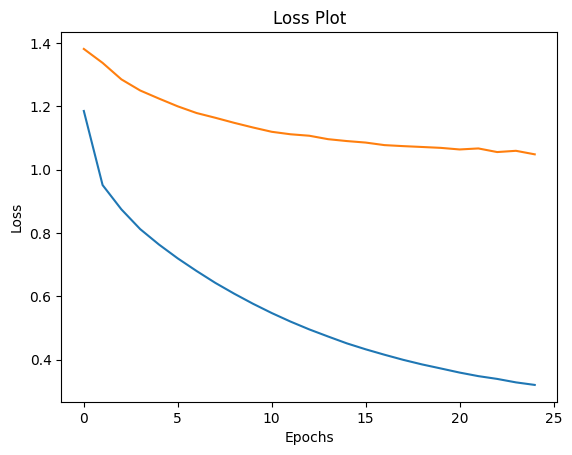

In [58]:
plt.plot(loss_plot)
plt.plot(test_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

#### NOTE: 
* Since there is a difference between the train & test steps ( Presence of teacher forcing), you may observe that the train loss is decreasing while your test loss is not. 
* This doesn't mean that the model is overfitting, as we can't compare the train & test results here, as both approach is different.
* Also, if you want to achieve better results you can run it more epochs, but the intent of this capstone is to give you an idea on how to integrate attention mechanism with E-D architecture for images. The intent is not to create the state of art model. 

## Model Evaluation
1.Define your evaluation function using greedy search

2.Define your evaluation function using beam search ( optional)

3.Test it on a sample data using BLEU score

### Greedy Search

In [117]:
attention_features_shape = 64
max_sequence_len = max_length # 39

In [118]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0) #process the input image to desired format before extracting features
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)
    dec_input = tf.expand_dims([tokenizer.word_index['start']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,features,hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = predictions.numpy()[0].argmax()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

### Beam Search(optional)

In [ ]:
# def beam_evaluate(image, beam_index = #your value for beam index):

#     #write your code to evaluate the result using beam search
                  
#     return final_caption



In [133]:
def plot_attmap(caption, weights, image):

    fig = plt.figure(figsize=(10, 10))
    temp_img = np.array(Image.open(image))
    
    len_cap = len(caption)
    for cap in range(len_cap):
        weights_img = np.reshape(weights[cap], (8,8))
        weights_img = np.array(Image.fromarray(weights_img).resize((124, 124), Image.LANCZOS))
        
        ax = fig.add_subplot(len_cap//2, len_cap//2, cap+1)
        ax.set_title(caption[cap], fontsize=15)
        
        img=ax.imshow(temp_img)
        
        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent())
        ax.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

In [121]:
def filt_text(text):
    filt=['<start>','<unk>','<end>'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

BELU score: 5.1336528580230934e-61
Real Caption: a happy baby wears an orange life vest
Prediction Caption: a life jacket


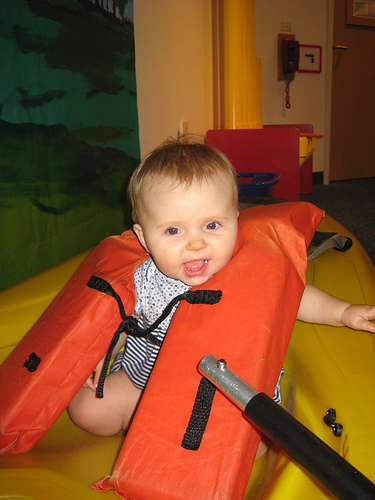

In [161]:
rid = np.random.randint(0, len(path_test))
test_image = path_test[rid]

real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test[rid] if i not in [0]])
result, attention_plot = evaluate(test_image)


real_caption=filt_text(real_caption)      


pred_caption=' '.join(result).rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()

score = sentence_bleu(reference, candidate, weights=(0.2,0.2,0,0))
print(f"BELU score: {score*100}")

print ('Real Caption:', real_caption)
print ('Prediction Caption:', pred_caption)


Image.open(test_image)

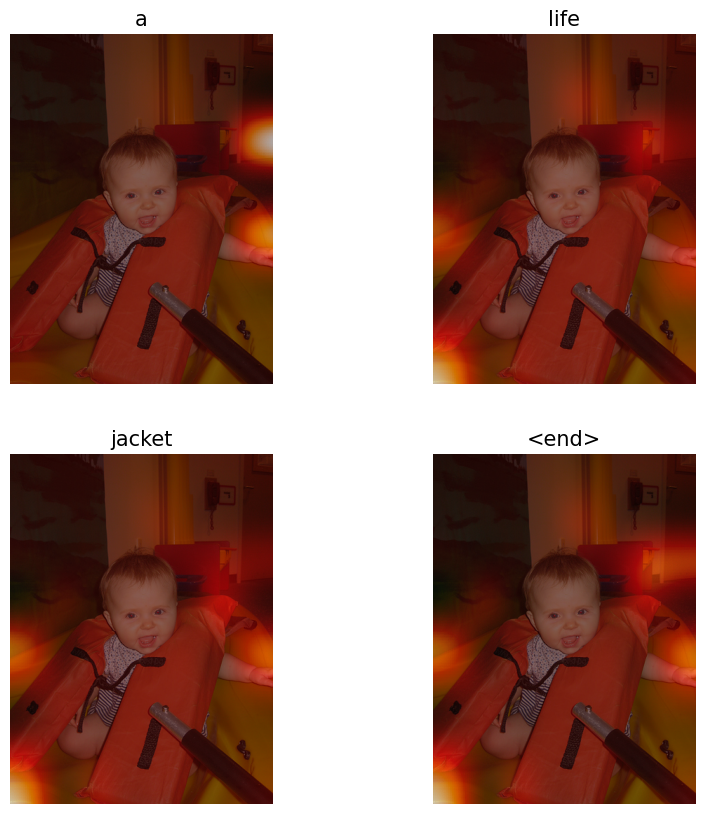

In [162]:
plot_attmap(result, attention_plot, test_image)

**Converting the caption to audio using Google Text-to-Speech(gTTS) API**

In [124]:
!pip install gTTS
!pip install playsound

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [125]:
from gtts import gTTS
from IPython import display
from IPython.display import Audio 

In [163]:
speech = gTTS(""+ pred_caption, lang = 'en', slow = False) 
audio_file = 'voice.mp3'
speech.save(audio_file)
print("\n\n"+start+'PLAY THE AUDIO: '+end)
display.display(display.Audio(audio_file, rate=None, autoplay=False))
    



PLAY THE AUDIO: 


In [ ]:
# captions=beam_evaluate(test_image)
# print(captions)